In [4]:
import numpy as np


def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [5]:
import matplotlib.pyplot as plt

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(path_XYs):
        # c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

In [3]:
path_XYs =  read_csv("./problems/frag2.csv")

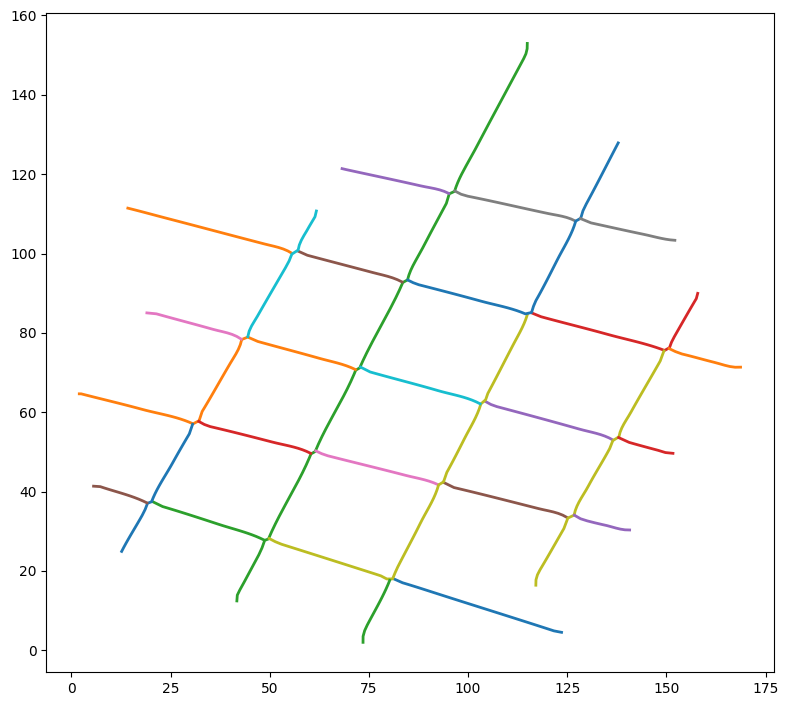

In [4]:
plot(path_XYs)

In [7]:
def normalize_points(paths):
    normalized_paths = []
    for path in paths:
        normalized_path = []
        for points in path:
            center = np.mean(points, axis=0)
            normalized_points = points - center
            scale = np.max(np.linalg.norm(normalized_points, axis=1))
            normalized_points /= scale
            normalized_path.append(normalized_points)
        normalized_paths.append(normalized_path)
    return normalized_paths

def smooth_points(paths, window_size=5):
    smoothed_paths = []
    for path in paths:
        smoothed_path = []
        for points in path:
            if len(points) >= window_size:
                smoothed_x = np.convolve(points[:, 0], np.ones(window_size)/window_size, mode='valid')
                smoothed_y = np.convolve(points[:, 1], np.ones(window_size)/window_size, mode='valid')
                smoothed_points = np.vstack((smoothed_x, smoothed_y)).T
                smoothed_path.append(smoothed_points)
            else:
                smoothed_path.append(points)
        smoothed_paths.append(smoothed_path)
    return smoothed_paths

In [6]:
def calculate_curvature(points):
    n = len(points)
    curvature = np.zeros(n)
    for i in range(1, n-1):
        p1, p2, p3 = points[i-1], points[i], points[i+1]
        v1 = p2 - p1
        v2 = p3 - p2
        angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
        angle = (angle + np.pi) % (2 * np.pi) - np.pi
        length1 = np.linalg.norm(v1)
        length2 = np.linalg.norm(v2)
        curvature[i] = angle / (length1 + length2)
    return curvature

def analyze_angles(points):
    n = len(points)
    angles = np.zeros(n-2)
    for i in range(1, n-1):
        v1 = points[i] - points[i-1]
        v2 = points[i+1] - points[i]
        angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
        angle = (angle + np.pi) % (2 * np.pi) - np.pi
        angles[i-1] = angle
    return angles

def check_symmetry(points):
    n = len(points)
    symmetry_score = 0
    for i in range(n // 2):
        if np.allclose(points[i], points[n-1-i], atol=1e-2):
            symmetry_score += 1
    return symmetry_score / (n // 2)

def extract_features(paths):
    features = []
    for path in paths:
        for points in path:
            curvature = calculate_curvature(points)
            angles = analyze_angles(points)
            symmetry_score = check_symmetry(points)
            features.append({
                'curvature': curvature,
                'angles': angles,
                'symmetry_score': symmetry_score
            })
    return features

In [8]:
normalised_path = normalize_points(path_XYs)

In [9]:
smoothened_points = smooth_points(normalised_path)

In [10]:
features = extract_features(smoothened_points)

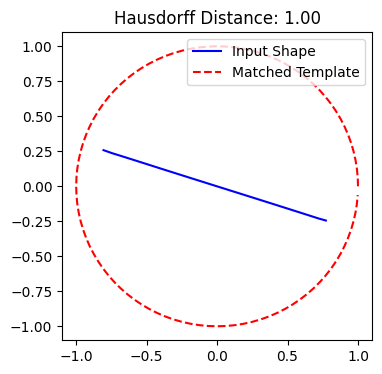

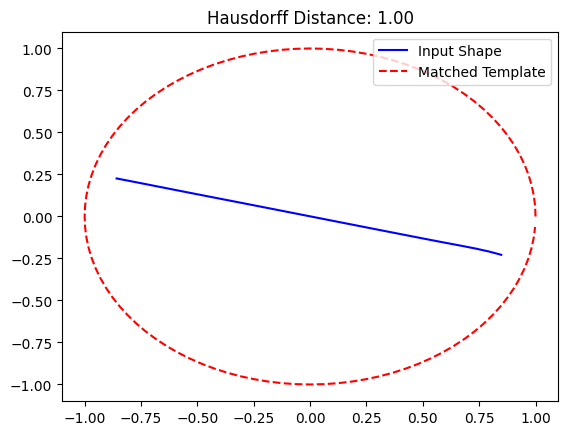

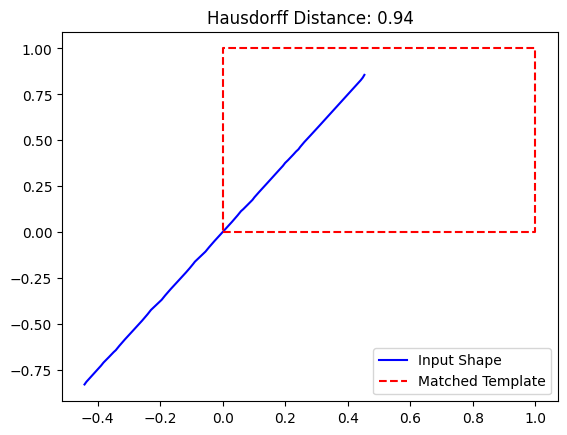

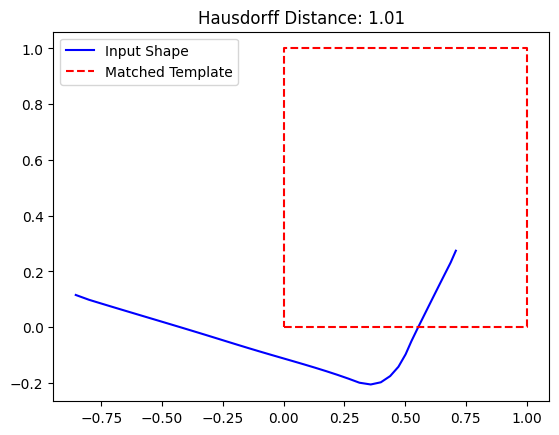

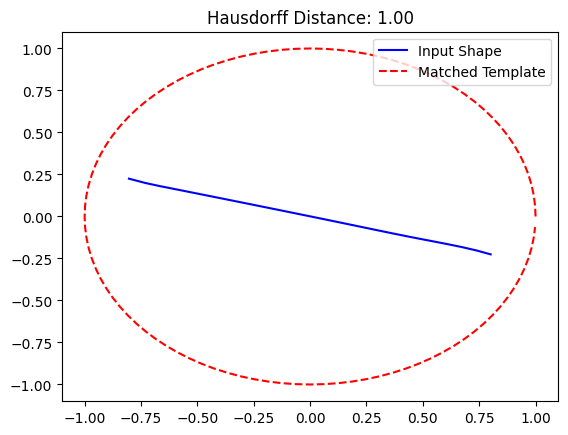

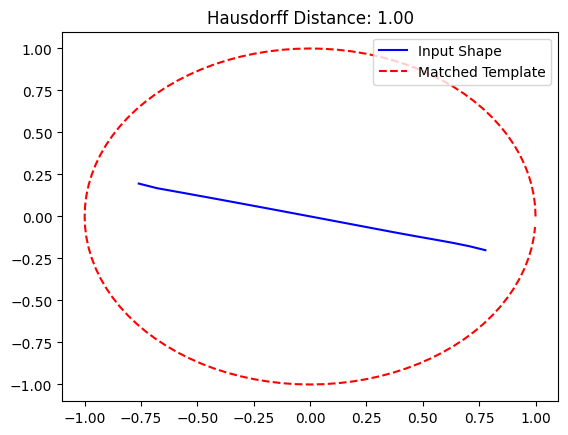

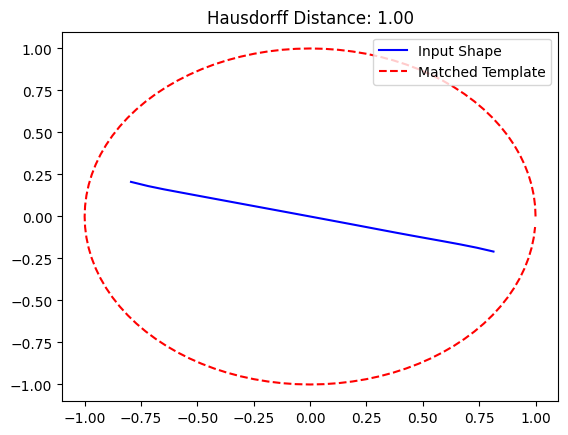

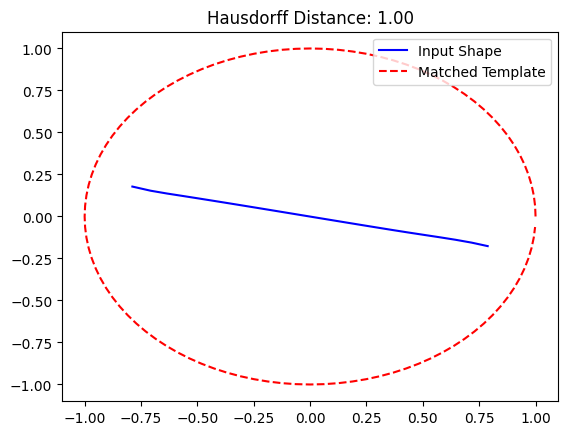

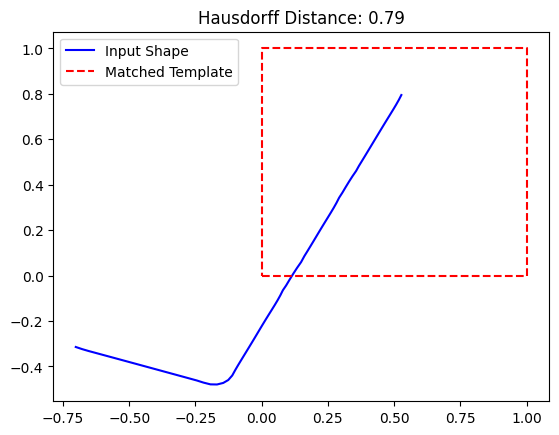

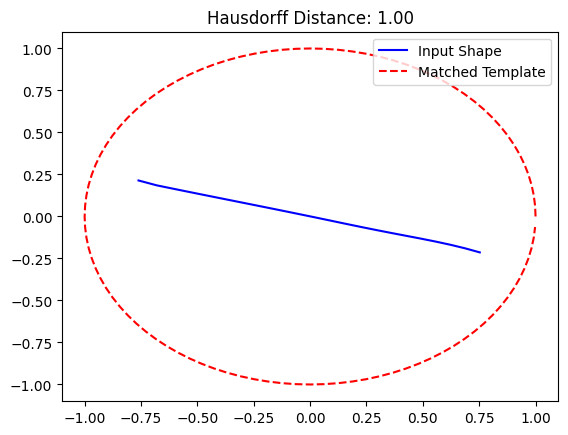

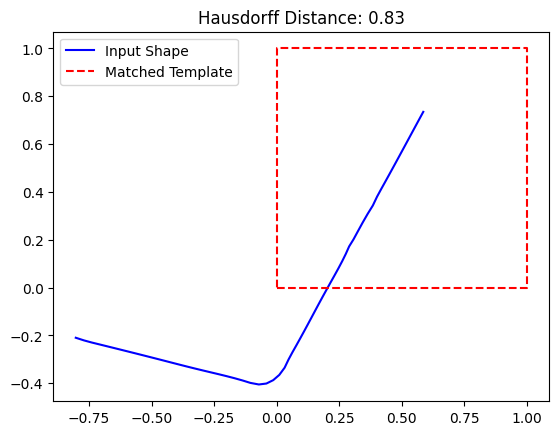

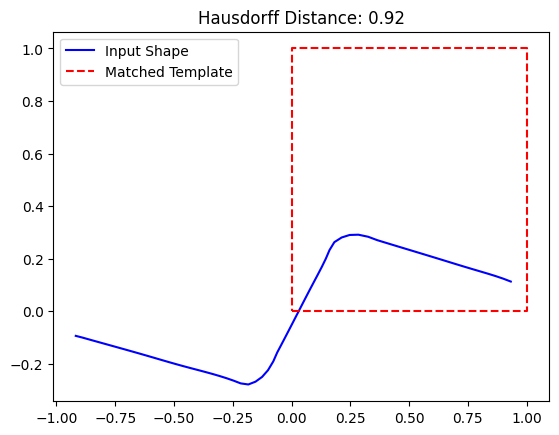

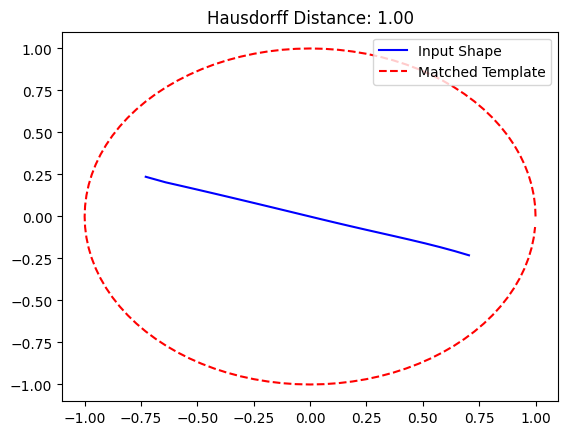

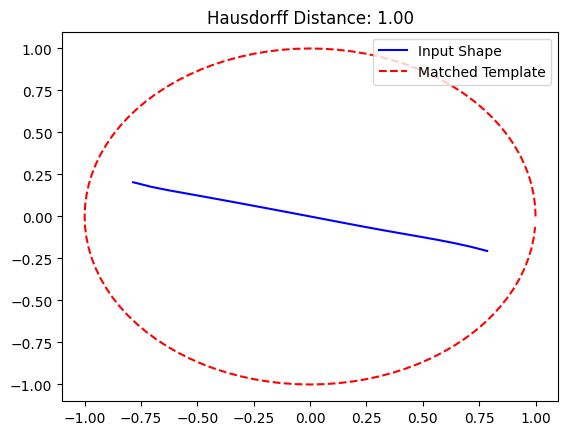

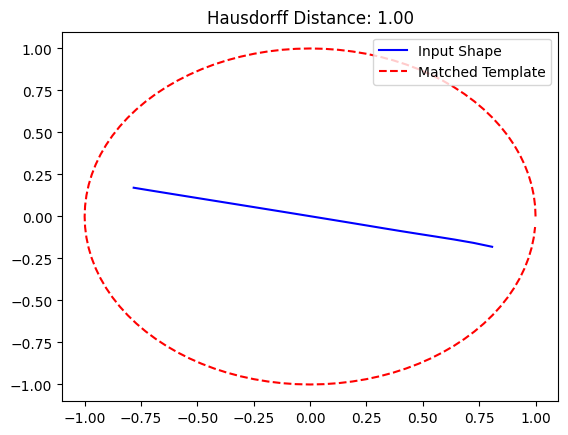

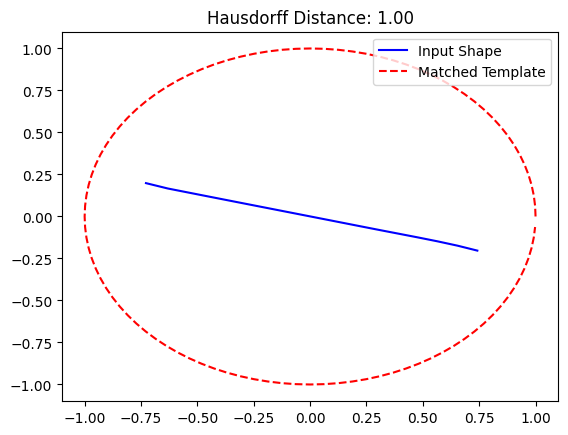

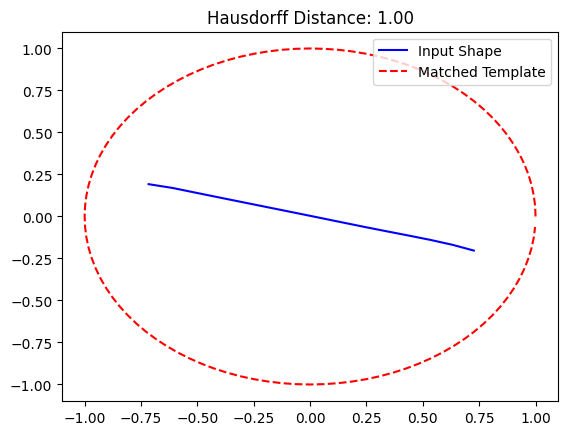

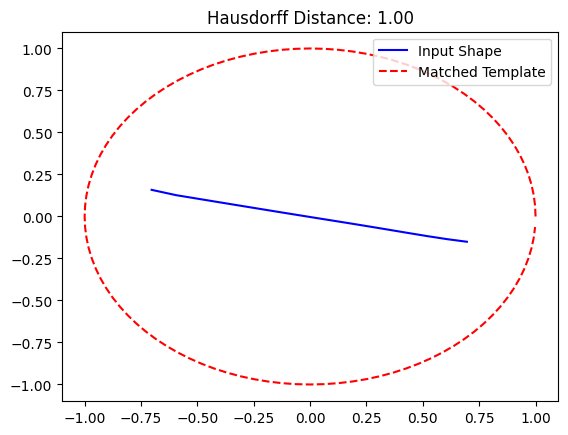

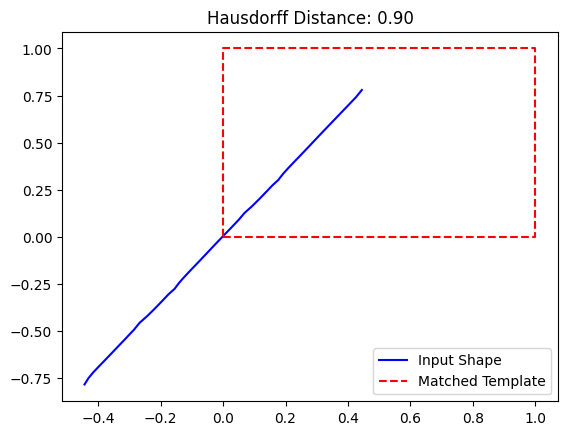

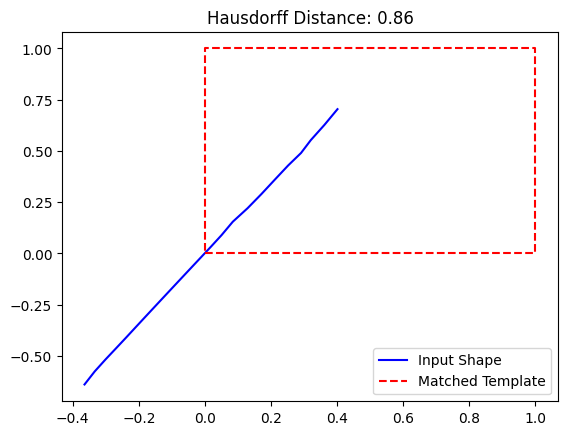

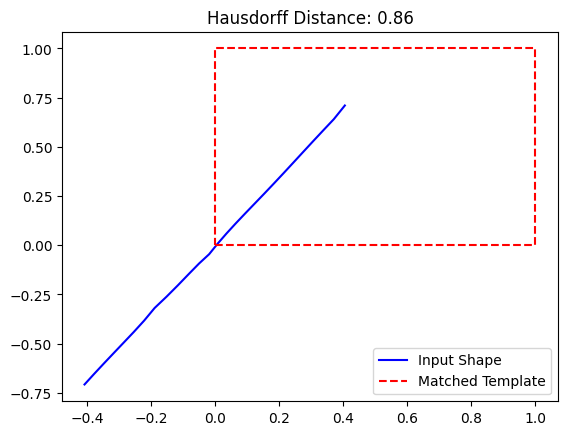

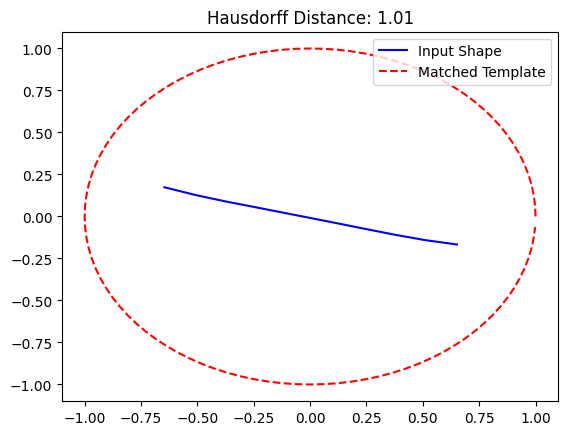

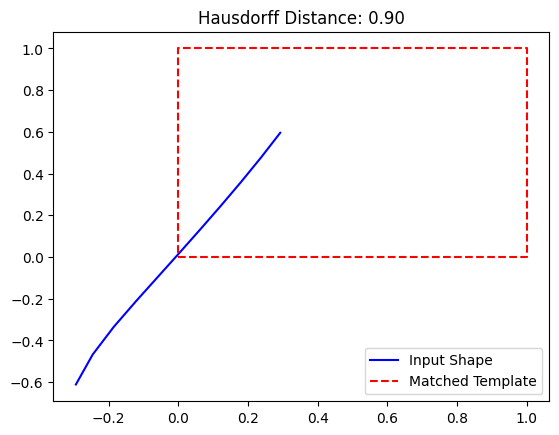

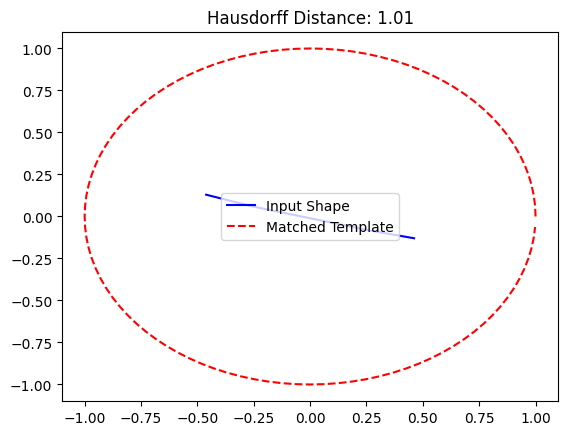

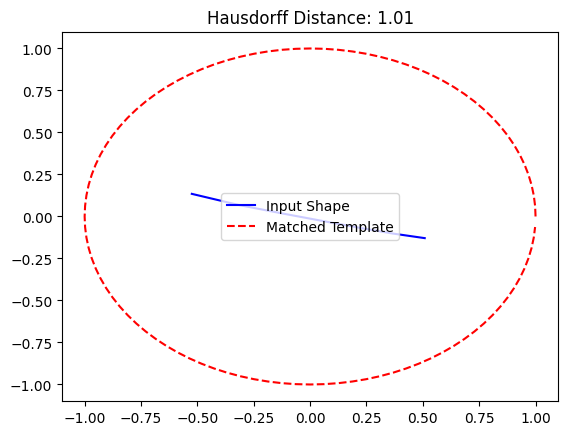

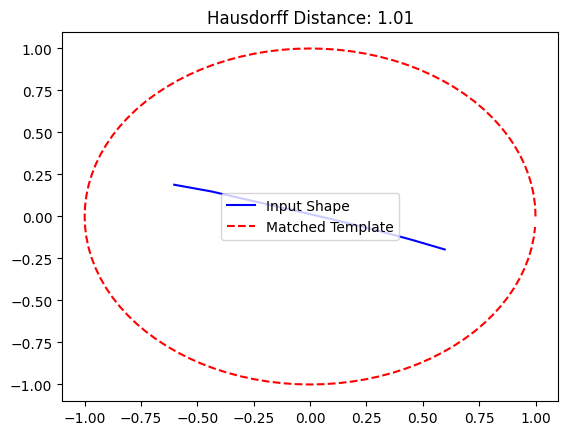

In [12]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from scipy.fftpack import fft

# Example regular shape templates (simple circles and squares)
def create_circle_points(radius, num_points):
    return np.array([(radius * np.cos(2 * np.pi * i / num_points), radius * np.sin(2 * np.pi * i / num_points)) for i in range(num_points)])

def create_square_points(side_length, num_points):
    quarter_points = num_points // 4
    return np.concatenate([
        np.column_stack([np.linspace(0, side_length, quarter_points), np.zeros(quarter_points)]),
        np.column_stack([np.full(quarter_points, side_length), np.linspace(0, side_length, quarter_points)]),
        np.column_stack([np.linspace(side_length, 0, quarter_points), np.full(quarter_points, side_length)]),
        np.column_stack([np.zeros(quarter_points), np.linspace(side_length, 0, quarter_points)])
    ])

circle_template = create_circle_points(1, 100)
square_template = create_square_points(1, 100)
templates = [circle_template, square_template]

def hausdorff_distance(A, B):
    d_AB = directed_hausdorff(A, B)[0]
    d_BA = directed_hausdorff(B, A)[0]
    return max(d_AB, d_BA)

def fourier_descriptors(points, num_descriptors=10):
    complex_points = points[:, 0] + 1j * points[:, 1]
    descriptors = fft(complex_points)
    return descriptors[:num_descriptors]

def compare_fourier(descriptors1, descriptors2):
    return np.linalg.norm(descriptors1 - descriptors2)

def template_matching(points, templates):
    min_distance = float('inf')
    best_template = None
    for template in templates:
        hd = hausdorff_distance(points, template)
        if hd < min_distance:
            min_distance = hd
            best_template = template
    return best_template, min_distance

def fourier_template_matching(points, templates, num_descriptors=10):
    min_distance = float('inf')
    best_template = None
    descriptors1 = fourier_descriptors(points, num_descriptors)
    for template in templates:
        descriptors2 = fourier_descriptors(template, num_descriptors)
        distance = compare_fourier(descriptors1, descriptors2)
        if distance < min_distance:
            min_distance = distance
            best_template = template
    return best_template, min_distance

# Example usage
# Assuming 'smoothed_paths' is a list of paths obtained from previous steps
matched_shapes = []
for path in smoothened_points:
    for points in path:
        best_template, distance = template_matching(points, templates)
        matched_shapes.append((points, best_template, distance))
        # Or use Fourier descriptors
        # best_template, distance = fourier_template_matching(points, templates)
        # matched_shapes.append((points, best_template, distance))

# Function to visualize the matched shapes
import matplotlib.pyplot as plt

def plot_matched_shapes(matched_shapes):
    plt.figure(figsize=(4,4))
    for points, template, distance in matched_shapes:
        plt.plot(points[:, 0], points[:, 1], 'b-', label='Input Shape')
        plt.plot(template[:, 0], template[:, 1], 'r--', label='Matched Template')
        plt.legend()
        plt.title(f'Hausdorff Distance: {distance:.2f}')
        plt.show()

# Example usage to visualize
plot_matched_shapes(matched_shapes)


In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'features' is a list of dictionaries containing 'curvature', 'angles', and 'symmetry_score'
# and 'labels' is a list of corresponding labels (0 for irregular, 1 for regular)

def prepare_dataset(features, labels):
    feature_vectors = []
    for feature in features:
        curvature_mean = np.mean(feature['curvature'])
        curvature_std = np.std(feature['curvature'])
        angles_mean = np.mean(feature['angles'])
        angles_std = np.std(feature['angles'])
        symmetry_score = feature['symmetry_score']
        feature_vector = [curvature_mean, curvature_std, angles_mean, angles_std, symmetry_score]
        feature_vectors.append(feature_vector)
    return np.array(feature_vectors), np.array(labels)

# Example feature extraction and labeling process
# Normally, you would have actual labels for your dataset
# Here we assume a dummy process for illustration
# features = extract_features(smoothed_paths)
labels = [1 if np.random.rand() > 0.5 else 0 for _ in range(len(features))]  # Random labels for illustration

# Prepare the dataset
X, y = prepare_dataset(features, labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM classifier
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Example usage
# csv_path = 'path_to_your_csv_file.csv'
# paths = read_csv(csv_path)
# normalized_paths = normalize_points(paths)
# smoothed_paths = smooth_points(normalized_paths)
# features = extract_features(smoothed_paths)
# labels = [...]  # Actual labels for your dataset
# X, y = prepare_dataset(features, labels)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# classifier = SVC(kernel='linear')
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)


Accuracy: 0.33
Precision: 0.33
Recall: 1.00
F1 Score: 0.50


Symmetry Finding

In [11]:
import numpy as np
import math
from scipy.spatial import KDTree
from scipy.optimize import minimize

# Helper function to create Bézier curve points
def bezier_curve(points, n=100):
    t = np.linspace(0, 1, n)
    curve = np.zeros((n, 2))
    n_points = len(points)
    for i in range(n_points):
        binomial_coeff = math.factorial(n_points - 1) / (math.factorial(i) * math.factorial(n_points - 1 - i))
        curve += binomial_coeff * (1 - t)**(n_points - 1 - i) * t**i * points[i]
    return curve

# Function to fit Bézier curve
def fit_bezier(points, num_control_points=4):
    def bezier_loss(control_points, points):
        control_points = control_points.reshape((num_control_points, 2))
        curve_points = bezier_curve(control_points)
        tree = KDTree(curve_points)
        dists, _ = tree.query(points)
        return np.mean(dists)

    initial_control_points = points[np.linspace(0, len(points) - 1, num_control_points).astype(int)]
    result = minimize(bezier_loss, initial_control_points.flatten(), args=(points,))
    return result.x.reshape((num_control_points, 2))

# Function to check symmetry
def check_symmetry(points, tolerance=1e-2):
    n = len(points)
    symmetry_points = []
    for i in range(n // 2):
        if np.allclose(points[i], points[n - 1 - i], atol=tolerance):
            symmetry_points.append((points[i], points[n - 1 - i]))
    return symmetry_points

# Example usage
csv_path = './problems/frag0.csv'
paths = read_csv(csv_path)
normalized_paths = normalize_points(paths)
smoothed_paths = smooth_points(normalized_paths)

for path in smoothed_paths:
    for points in path:
        symmetry_points = check_symmetry(points)
        if symmetry_points:
            symmetric_points = np.array([pt for pair in symmetry_points for pt in pair])
            bezier_points = fit_bezier(symmetric_points)
            
            # Visualize the result
            import matplotlib.pyplot as plt
            plt.plot(points[:, 0], points[:, 1], 'b-', label='Original Shape')
            fitted_curve = bezier_curve(bezier_points)
            plt.plot(fitted_curve[:, 0], fitted_curve[:, 1], 'r--', label='Fitted Bézier Curve')
            plt.legend()
            plt.show()


ValueError: operands could not be broadcast together with shapes (100,) (2,) 

ISOLATION

In [22]:
import numpy as np

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Debugging Step: Print the loaded data
csv_path = './problems/isolated.csv'
paths = read_csv(csv_path)
print("Loaded Paths:", paths)


Loaded Paths: [[array([[109.14299774, 125.58000183],
       [110.15747833, 125.49578094],
       [111.17194366, 125.40398407],
       [112.18638611, 125.30522156],
       [113.20079041, 125.20011139],
       [114.21517181, 125.08926392],
       [115.22950745, 124.97328949],
       [116.2437973 , 124.85279083],
       [117.25804138, 124.72838593],
       [118.27222443, 124.60068512],
       [119.28635406, 124.47029877],
       [120.30041504, 124.33782959],
       [121.31440735, 124.2039032 ],
       [122.32831573, 124.06912231],
       [123.34214783, 123.93410492],
       [124.355896  , 123.79945374],
       [125.36954498, 123.66577911],
       [126.38310242, 123.53369141],
       [127.39655304, 123.40380859],
       [128.40989685, 123.27674103],
       [129.42312622, 123.15309143],
       [130.43623352, 123.03347778],
       [131.44923401, 122.91851044],
       [132.46208191, 122.80879974],
       [133.47480774, 122.70494843],
       [134.48739624, 122.60758209],
       [135.49983215, 

In [23]:
from scipy.signal import savgol_filter

def normalize_points(paths):
    normalized_paths = []
    for path in paths:
        norm_path = []
        for points in path:
            mean = np.mean(points, axis=0)
            std = np.std(points, axis=0)
            norm_points = (points - mean) / std
            norm_path.append(norm_points)
        normalized_paths.append(norm_path)
    return normalized_paths

def smooth_points(paths, window_length=5, polyorder=3):
    smoothed_paths = []
    for path in paths:
        smooth_path = []
        for points in path:
            x_smooth = savgol_filter(points[:, 0], window_length, polyorder)
            y_smooth = savgol_filter(points[:, 1], window_length, polyorder)
            smooth_points = np.vstack((x_smooth, y_smooth)).T
            smooth_path.append(smooth_points)
        smoothed_paths.append(smooth_path)
    return smoothed_paths


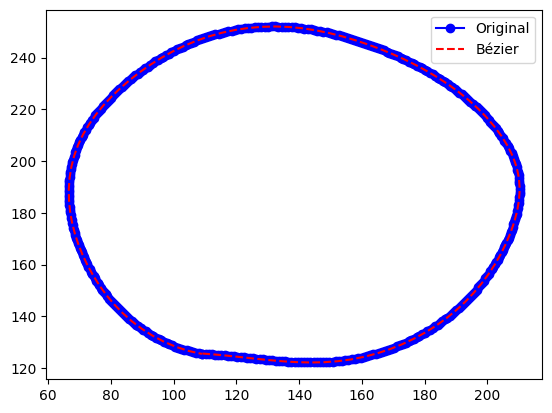

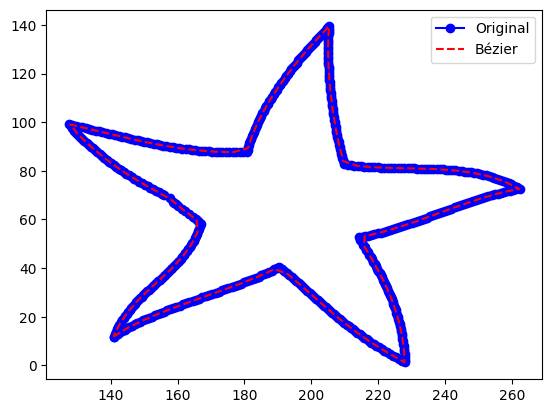

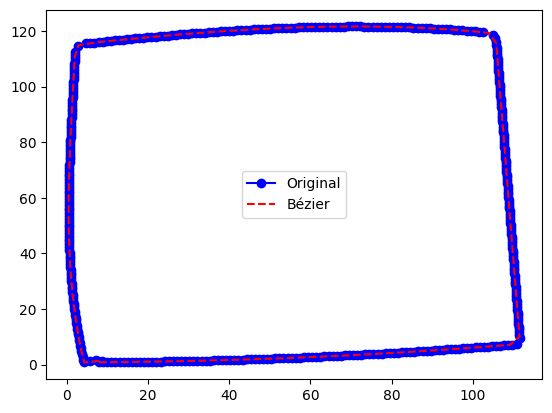

In [26]:
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

def fit_cubic_bezier_curve(points, num_points=100):
    tck, u = splprep([points[:, 0], points[:, 1]], s=0, k=3)
    u_new = np.linspace(u.min(), u.max(), num_points)
    x_new, y_new = splev(u_new, tck, der=0)
    bezier_points = np.vstack((x_new, y_new)).T
    return bezier_points

# Debugging Step: Visualize the fitted Bézier curve
for path in paths:
    for points in path:
        bezier_points = fit_cubic_bezier_curve(points)
        plt.plot(points[:, 0], points[:, 1], 'bo-', label='Original')
        plt.plot(bezier_points[:, 0], bezier_points[:, 1], 'r--', label='Bézier')
        plt.legend()
        plt.show()


Regularized Paths: [[array([[109.14299774, 125.58000183],
       [113.46201571, 125.17209003],
       [117.77051193, 124.66423262],
       [122.07245044, 124.1031826 ],
       [126.37345093, 123.53493984],
       [130.67935942, 123.00543941],
       [134.99484485, 122.56141168],
       [139.321868  , 122.25089959],
       [143.65797461, 122.12322477],
       [147.99449279, 122.22783698],
       [152.31502512, 122.61167871],
       [156.59507388, 123.31450417],
       [160.80974795, 124.33910929],
       [164.93793151, 125.67022937],
       [168.96085773, 127.29204304],
       [172.86169768, 129.1888888 ],
       [176.62509056, 131.3456758 ],
       [180.23659942, 133.74818579],
       [183.68225707, 136.38306734],
       [186.94805849, 139.23783862],
       [190.02276007, 142.29754813],
       [192.9012584 , 145.54257741],
       [195.5788547 , 148.95531562],
       [198.05232348, 152.51881991],
       [200.31950038, 156.21703479],
       [202.37895827, 160.03485503],
       [204.22957

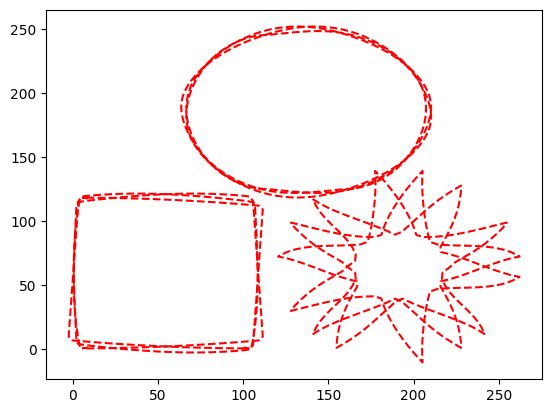

In [27]:
def detect_symmetry(points):
    centroid = np.mean(points, axis=0)
    points_mirrored_x = points.copy()
    points_mirrored_x[:, 0] = 2 * centroid[0] - points[:, 0]  # Horizontal symmetry
    points_mirrored_y = points.copy()
    points_mirrored_y[:, 1] = 2 * centroid[1] - points[:, 1]  # Vertical symmetry
    return points, points_mirrored_x, points_mirrored_y

def regularize_shapes(paths):
    regularized_paths = []
    for path in paths:
        regularized_path = []
        for points in path:
            bezier_points = fit_cubic_bezier_curve(points)
            original, symmetric_x, symmetric_y = detect_symmetry(bezier_points)
            regularized_path.append(original)
            # Only add distinct symmetrical transformations
            if not np.array_equal(original, symmetric_x):
                regularized_path.append(symmetric_x)
            if not np.array_equal(original, symmetric_y):
                regularized_path.append(symmetric_y)
        regularized_paths.append(regularized_path)
    return regularized_paths

# Debugging Step: Print and visualize the regularized shapes
regularized_paths = regularize_shapes(paths)
print("Regularized Paths:", regularized_paths)
for path in regularized_paths:
    for points in path:
        plt.plot(points[:, 0], points[:, 1], 'r--')
plt.show()


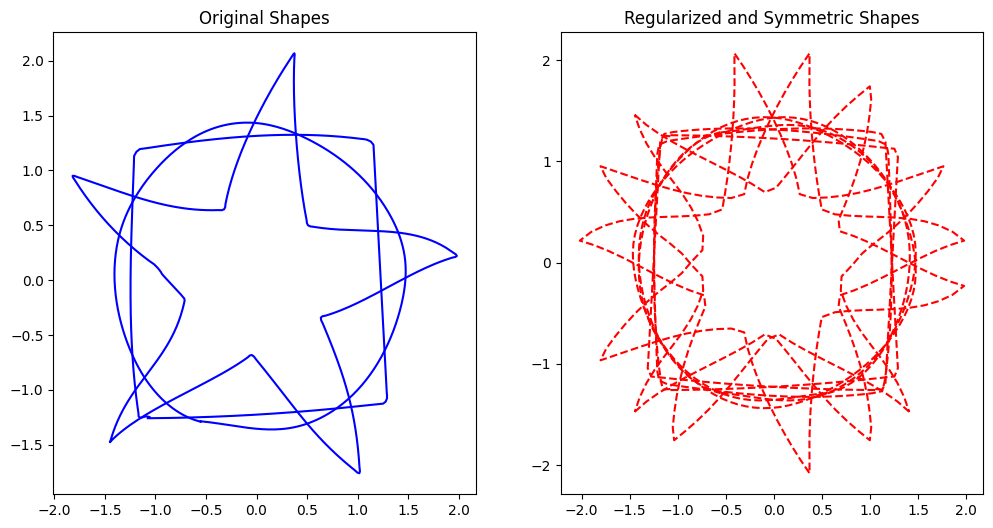

In [28]:
def visualize_results(paths, regularized_paths):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    for path in paths:
        for points in path:
            ax[0].plot(points[:, 0], points[:, 1], 'b-')
    ax[0].set_title('Original Shapes')

    for path in regularized_paths:
        for points in path:
            ax[1].plot(points[:, 0], points[:, 1], 'r--')
    ax[1].set_title('Regularized and Symmetric Shapes')
    plt.show()

# Example usage
csv_path = './problems/isolated.csv'
paths = read_csv(csv_path)
normalized_paths = normalize_points(paths)
smoothed_paths = smooth_points(normalized_paths)
regularized_paths = regularize_shapes(smoothed_paths)
visualize_results(smoothed_paths, regularized_paths)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.signal import savgol_filter


def ramer_douglas_peucker(points, epsilon):
    def point_line_distance(point, start, end):
        if np.array_equal(start, end):
            return distance.euclidean(point, start)
        else:
            n = abs((end[1] - start[1]) * point[0] - (end[0] - start[0]) * point[1] + end[0] * start[1] - end[1] * start[0])
            d = np.sqrt((end[1] - start[1]) ** 2 + (end[0] - start[0]) ** 2)
            return n / d

    def rdp(points, epsilon):
        dmax = 0
        index = 0
        end = len(points)
        for i in range(1, end - 1):
            d = point_line_distance(points[i], points[0], points[end - 1])
            if d > dmax:
                index = i
                dmax = d
        if dmax > epsilon:
            results1 = rdp(points[:index + 1], epsilon)
            results2 = rdp(points[index:], epsilon)
            return results1[:-1] + results2
        else:
            return [points[0], points[end - 1]]

    return np.array(rdp(points.tolist(), epsilon))


In [10]:
def detect_symmetry(points):
    centroid = np.mean(points, axis=0)
    points_mirrored_x = points.copy()
    points_mirrored_x[:, 0] = 2 * centroid[0] - points[:, 0]  # Horizontal symmetry
    points_mirrored_y = points.copy()
    points_mirrored_y[:, 1] = 2 * centroid[1] - points[:, 1]  # Vertical symmetry
    return points, points_mirrored_x, points_mirrored_y


In [15]:
def regularize_shapes(paths, epsilon=0.01):
    regularized_paths = []
    for path in paths:
        regularized_path = []
        for points in path:
            # Apply RDP algorithm
            rdp_points = ramer_douglas_peucker(points, epsilon)
            regularized_path.append(rdp_points)
        regularized_paths.append(regularized_path)
    return regularized_paths


In [16]:
def visualize_results(paths, regularized_paths):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].set_title('Original Shapes')
    for path in paths:
        for points in path:
            ax[0].plot(points[:, 0], points[:, 1], 'b-')

    ax[1].set_title('Regularized Shapes')
    for path in regularized_paths:
        for points in path:
            ax[1].plot(points[:, 0], points[:, 1], 'r--')

    plt.show()

def debug_intermediate_steps(points, rdp_points, title):
    plt.figure(figsize=(6, 6))
    plt.plot(points[:, 0], points[:, 1], 'b-', label='Original')
    plt.plot(rdp_points[:, 0], rdp_points[:, 1], 'ro--', label='RDP')
    plt.title(title)
    plt.legend()
    plt.show()


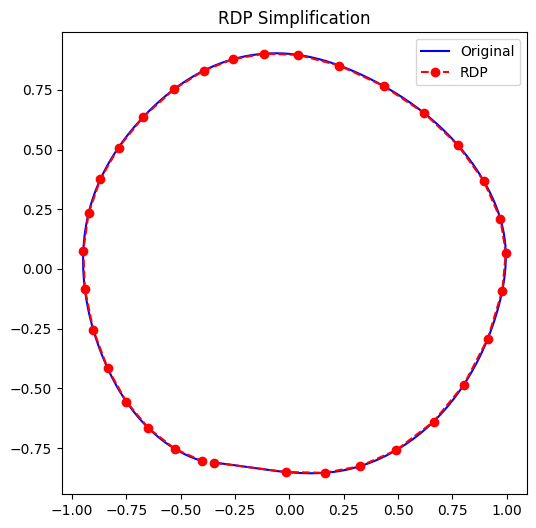

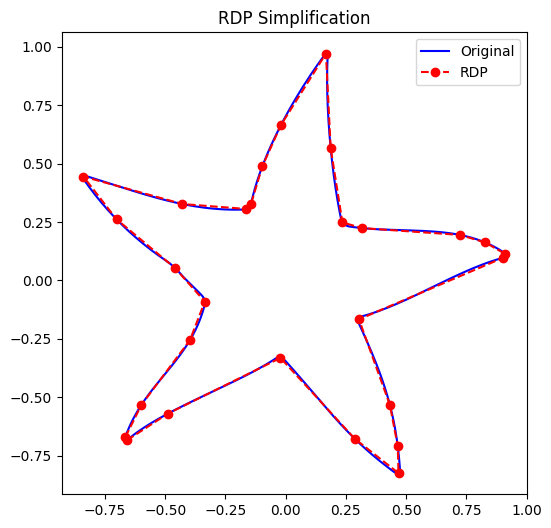

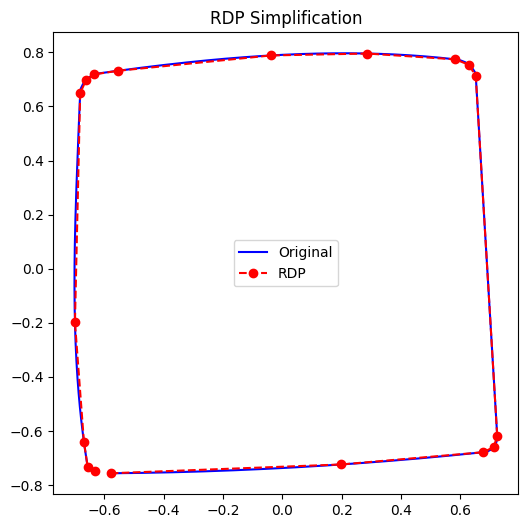

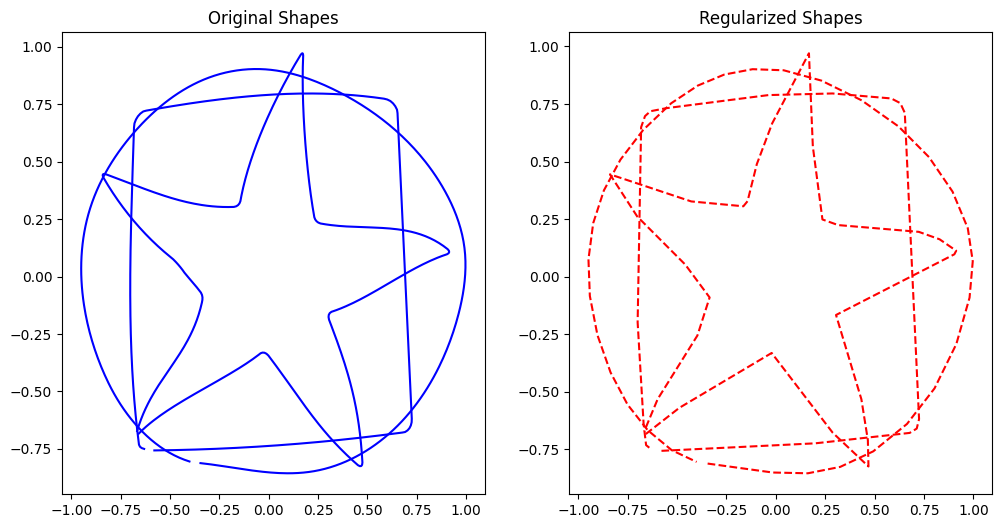

In [17]:
# Example usage
csv_path = './problems/isolated.csv'
paths = read_csv(csv_path)  # Replace with actual CSV reading function
normalized_paths = normalize_points(paths)  # Replace with actual normalization function
smoothed_paths = smooth_points(normalized_paths)  # Replace with actual smoothing function

# Debugging intermediate steps
for path in smoothed_paths:
    for points in path:
        rdp_points = ramer_douglas_peucker(points, epsilon=0.01)
        debug_intermediate_steps(points, rdp_points, "RDP Simplification")

regularized_paths = regularize_shapes(smoothed_paths, epsilon=0.01)
visualize_results(smoothed_paths, regularized_paths)


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

def ramer_douglas_peucker(points, epsilon):
    def point_line_distance(point, start, end):
        if np.array_equal(start, end):
            return distance.euclidean(point, start)
        else:
            n = abs((end[1] - start[1]) * point[0] - (end[0] - start[0]) * point[1] + end[0] * start[1] - end[1] * start[0])
            d = np.sqrt((end[1] - start[1]) ** 2 + (end[0] - start[0]) ** 2)
            return n / d

    def rdp(points, epsilon):
        dmax = 0
        index = 0
        end = len(points)
        for i in range(1, end - 1):
            d = point_line_distance(points[i], points[0], points[end - 1])
            if d > dmax:
                index = i
                dmax = d
        if dmax > epsilon:
            results1 = rdp(points[:index + 1], epsilon)
            results2 = rdp(points[index:], epsilon)
            return results1[:-1] + results2
        else:
            return [points[0], points[end - 1]]

    return np.array(rdp(points.tolist(), epsilon))

def smooth_curve(points, window_size=5):
    smoothed_points = np.copy(points)
    for i in range(len(points)):
        if i < window_size:
            smoothed_points[i] = np.mean(points[:i + window_size], axis=0)
        elif i > len(points) - window_size:
            smoothed_points[i] = np.mean(points[i - window_size:], axis=0)
        else:
            smoothed_points[i] = np.mean(points[i - window_size:i + window_size], axis=0)
    return smoothed_points

def regularize_shapes(paths, epsilon=0.01, window_size=5):
    regularized_paths = []
    for path in paths:
        regularized_path = []
        for points in path:
            # Apply RDP algorithm
            rdp_points = ramer_douglas_peucker(points, epsilon)
            # Smooth the curve
            smoothed_points = smooth_curve(rdp_points, window_size)
            regularized_path.append(smoothed_points)
        regularized_paths.append(regularized_path)
    return regularized_paths

def visualize_results(paths, regularized_paths):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].set_title('Original Shapes')
    for path in paths:
        for points in path:
            ax[0].plot(points[:, 0], points[:, 1], 'b-')

    ax[1].set_title('Regularized Shapes')
    for path in regularized_paths:
        for points in path:
            ax[1].plot(points[:, 0], points[:, 1], 'r--')

    plt.show()


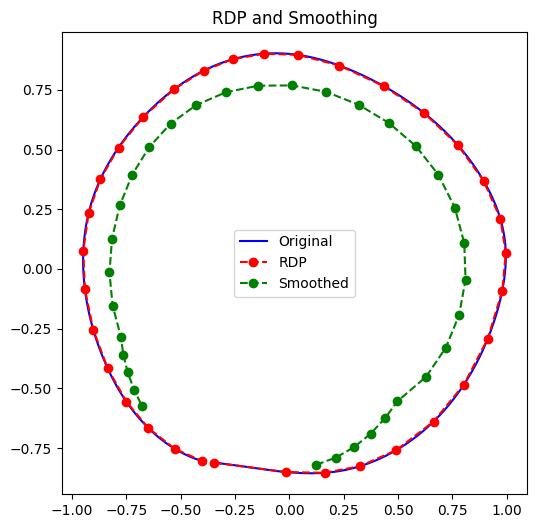

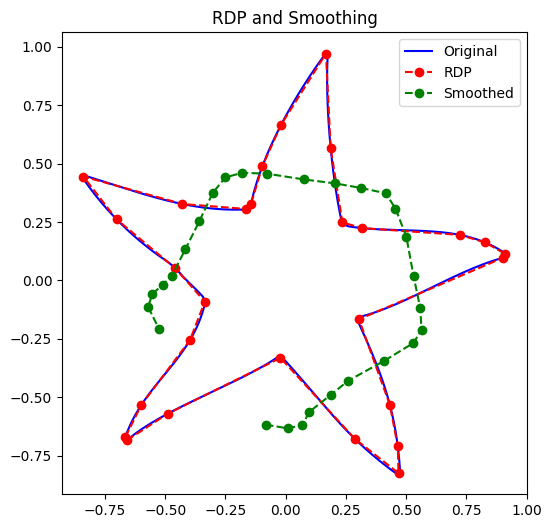

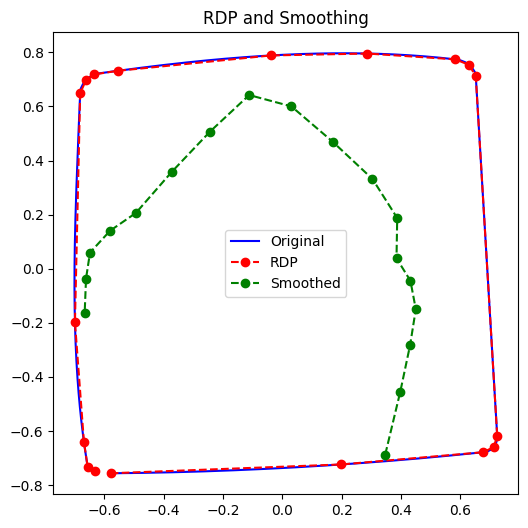

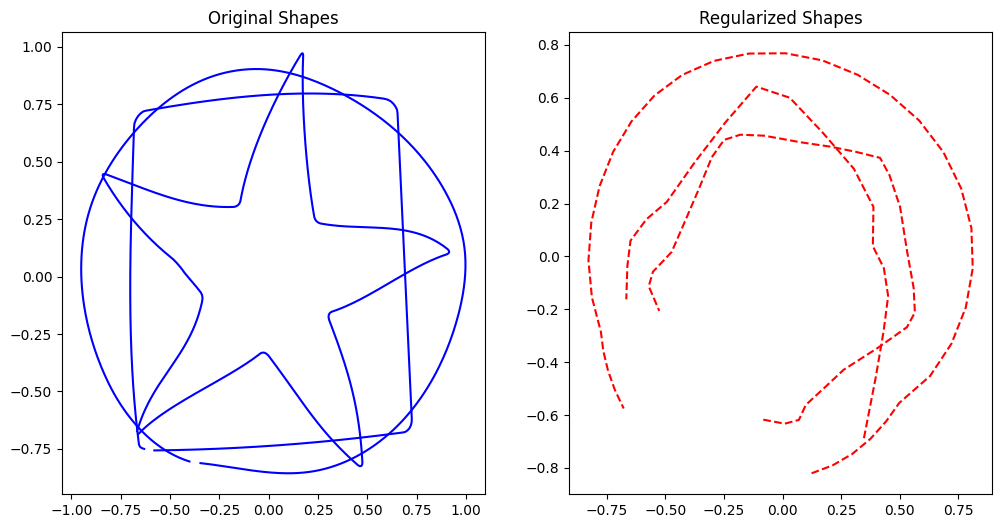

In [19]:
def debug_intermediate_steps(points, rdp_points, smoothed_points, title):
    plt.figure(figsize=(6, 6))
    plt.plot(points[:, 0], points[:, 1], 'b-', label='Original')
    plt.plot(rdp_points[:, 0], rdp_points[:, 1], 'ro--', label='RDP')
    plt.plot(smoothed_points[:, 0], smoothed_points[:, 1], 'go--', label='Smoothed')
    plt.title(title)
    plt.legend()
    plt.show()

# Example usage
csv_path = './problems/isolated.csv'
paths = read_csv(csv_path)  # Replace with actual CSV reading function
normalized_paths = normalize_points(paths)  # Replace with actual normalization function
smoothed_paths = smooth_points(normalized_paths)  # Replace with actual smoothing function

# Debugging intermediate steps
for path in smoothed_paths:
    for points in path:
        rdp_points = ramer_douglas_peucker(points, epsilon=0.01)
        smoothed_points = smooth_curve(rdp_points, window_size=5)
        debug_intermediate_steps(points, rdp_points, smoothed_points, "RDP and Smoothing")

regularized_paths = regularize_shapes(smoothed_paths, epsilon=0.01, window_size=5)
visualize_results(smoothed_paths, regularized_paths)
